In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 o7ee3ga8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-o7ee3ga8:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:7.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/2934 [00:00<30:10,  1.62it/s]

  0%|▎                                                                                                                                         | 6/2934 [00:00<04:33, 10.69it/s]

  0%|▌                                                                                                                                        | 11/2934 [00:00<02:33, 18.98it/s]

  1%|▊                                                                                                                                        | 17/2934 [00:00<01:46, 27.27it/s]

  1%|█                                                                                                                                        | 22/2934 [00:01<01:29, 32.70it/s]

  1%|█▎                                                                                                                                       | 27/2934 [00:01<01:18, 37.12it/s]

  1%|█▌                                                                                                                                       | 33/2934 [00:01<01:10, 41.08it/s]

  1%|█▊                                                                                                                                       | 39/2934 [00:01<01:06, 43.77it/s]

  2%|██                                                                                                                                       | 45/2934 [00:01<01:03, 45.71it/s]

  2%|██▍                                                                                                                                      | 51/2934 [00:01<01:01, 47.11it/s]

  2%|██▋                                                                                                                                      | 57/2934 [00:01<00:59, 47.99it/s]

  2%|██▉                                                                                                                                      | 63/2934 [00:01<00:58, 48.69it/s]

  2%|███▏                                                                                                                                     | 69/2934 [00:01<00:58, 49.17it/s]

  3%|███▌                                                                                                                                     | 75/2934 [00:02<00:57, 49.46it/s]

  3%|███▊                                                                                                                                     | 81/2934 [00:02<00:57, 49.65it/s]

  3%|████                                                                                                                                     | 87/2934 [00:02<00:57, 49.85it/s]

  3%|████▎                                                                                                                                    | 93/2934 [00:02<00:56, 49.98it/s]

  3%|████▌                                                                                                                                    | 99/2934 [00:02<00:56, 49.92it/s]

  4%|████▊                                                                                                                                   | 105/2934 [00:02<00:56, 49.95it/s]

  4%|█████▏                                                                                                                                  | 111/2934 [00:02<00:56, 50.03it/s]

  4%|█████▍                                                                                                                                  | 117/2934 [00:02<00:56, 50.03it/s]

  4%|█████▋                                                                                                                                  | 123/2934 [00:03<00:56, 50.10it/s]

  4%|█████▉                                                                                                                                  | 129/2934 [00:03<00:55, 50.17it/s]

  5%|██████▎                                                                                                                                 | 135/2934 [00:03<00:55, 50.11it/s]

  5%|██████▌                                                                                                                                 | 141/2934 [00:03<00:55, 50.18it/s]

  5%|██████▊                                                                                                                                 | 147/2934 [00:03<00:55, 50.16it/s]

  5%|███████                                                                                                                                 | 153/2934 [00:03<00:55, 50.21it/s]

  5%|███████▎                                                                                                                                | 159/2934 [00:03<00:55, 50.15it/s]

  6%|███████▋                                                                                                                                | 165/2934 [00:03<00:55, 50.22it/s]

  6%|███████▉                                                                                                                                | 171/2934 [00:04<00:55, 50.24it/s]

  6%|████████▏                                                                                                                               | 177/2934 [00:04<00:54, 50.18it/s]

  6%|████████▍                                                                                                                               | 183/2934 [00:04<00:54, 50.21it/s]

  6%|████████▊                                                                                                                               | 189/2934 [00:04<00:54, 50.23it/s]

  7%|█████████                                                                                                                               | 195/2934 [00:04<00:54, 50.17it/s]

  7%|█████████▎                                                                                                                              | 201/2934 [00:04<00:54, 50.15it/s]

  7%|█████████▌                                                                                                                              | 207/2934 [00:04<00:54, 50.07it/s]

  7%|█████████▊                                                                                                                              | 213/2934 [00:04<00:54, 50.11it/s]

  7%|██████████▏                                                                                                                             | 219/2934 [00:04<00:54, 50.09it/s]

  8%|██████████▍                                                                                                                             | 225/2934 [00:05<00:54, 50.11it/s]

  8%|██████████▋                                                                                                                             | 231/2934 [00:05<00:53, 50.17it/s]

  8%|██████████▉                                                                                                                             | 237/2934 [00:05<00:53, 50.13it/s]

  8%|███████████▎                                                                                                                            | 243/2934 [00:05<00:53, 50.22it/s]

  8%|███████████▌                                                                                                                            | 249/2934 [00:05<00:53, 50.24it/s]

  9%|███████████▊                                                                                                                            | 255/2934 [00:05<00:53, 50.28it/s]

  9%|████████████                                                                                                                            | 261/2934 [00:05<00:53, 50.25it/s]

  9%|████████████▍                                                                                                                           | 267/2934 [00:05<00:53, 50.28it/s]

  9%|████████████▋                                                                                                                           | 273/2934 [00:06<00:52, 50.24it/s]

 10%|████████████▉                                                                                                                           | 279/2934 [00:06<00:53, 50.09it/s]

 10%|█████████████▏                                                                                                                          | 285/2934 [00:06<00:52, 50.18it/s]

 10%|█████████████▍                                                                                                                          | 291/2934 [00:06<00:52, 50.15it/s]

 10%|█████████████▊                                                                                                                          | 297/2934 [00:06<00:52, 50.18it/s]

 10%|██████████████                                                                                                                          | 303/2934 [00:06<00:52, 50.22it/s]

 11%|██████████████▎                                                                                                                         | 309/2934 [00:06<00:52, 50.13it/s]

 11%|██████████████▌                                                                                                                         | 315/2934 [00:06<00:52, 50.04it/s]

 11%|██████████████▉                                                                                                                         | 321/2934 [00:06<00:52, 50.23it/s]

 11%|███████████████▏                                                                                                                        | 327/2934 [00:07<00:51, 50.26it/s]

 11%|███████████████▍                                                                                                                        | 333/2934 [00:07<00:51, 50.24it/s]

 12%|███████████████▋                                                                                                                        | 339/2934 [00:07<00:51, 50.17it/s]

 12%|███████████████▉                                                                                                                        | 345/2934 [00:07<00:51, 50.21it/s]

 12%|████████████████▎                                                                                                                       | 351/2934 [00:07<00:51, 50.23it/s]

 12%|████████████████▌                                                                                                                       | 357/2934 [00:07<00:51, 50.16it/s]

 12%|████████████████▊                                                                                                                       | 363/2934 [00:07<00:51, 50.26it/s]

 13%|█████████████████                                                                                                                       | 369/2934 [00:07<00:51, 50.24it/s]

 13%|█████████████████▍                                                                                                                      | 375/2934 [00:08<00:50, 50.21it/s]

 13%|█████████████████▋                                                                                                                      | 381/2934 [00:08<00:50, 50.26it/s]

 13%|█████████████████▉                                                                                                                      | 387/2934 [00:08<00:50, 50.27it/s]

 13%|██████████████████▏                                                                                                                     | 393/2934 [00:08<00:50, 50.17it/s]

 14%|██████████████████▍                                                                                                                     | 399/2934 [00:08<00:50, 50.17it/s]

 14%|██████████████████▊                                                                                                                     | 405/2934 [00:08<00:50, 50.26it/s]

 14%|███████████████████                                                                                                                     | 411/2934 [00:08<00:50, 50.17it/s]

 14%|███████████████████▎                                                                                                                    | 417/2934 [00:08<00:50, 50.19it/s]

 14%|███████████████████▌                                                                                                                    | 423/2934 [00:09<00:50, 50.17it/s]

 15%|███████████████████▉                                                                                                                    | 429/2934 [00:09<00:49, 50.16it/s]

 15%|████████████████████▏                                                                                                                   | 435/2934 [00:09<00:49, 50.20it/s]

 15%|████████████████████▍                                                                                                                   | 441/2934 [00:09<00:49, 50.19it/s]

 15%|████████████████████▋                                                                                                                   | 447/2934 [00:09<00:49, 50.22it/s]

 15%|████████████████████▉                                                                                                                   | 453/2934 [00:09<00:50, 49.08it/s]

 16%|█████████████████████▎                                                                                                                  | 459/2934 [00:09<00:49, 49.57it/s]

 16%|█████████████████████▌                                                                                                                  | 465/2934 [00:09<00:49, 49.79it/s]

 16%|█████████████████████▊                                                                                                                  | 471/2934 [00:09<00:49, 49.84it/s]

 16%|██████████████████████                                                                                                                  | 477/2934 [00:10<00:49, 49.97it/s]

 16%|██████████████████████▍                                                                                                                 | 483/2934 [00:10<00:48, 50.10it/s]

 17%|██████████████████████▋                                                                                                                 | 489/2934 [00:10<00:48, 50.16it/s]

 17%|██████████████████████▉                                                                                                                 | 495/2934 [00:10<00:48, 50.08it/s]

 17%|███████████████████████▏                                                                                                                | 501/2934 [00:10<00:48, 50.11it/s]

 17%|███████████████████████▌                                                                                                                | 507/2934 [00:10<00:48, 50.17it/s]

 17%|███████████████████████▊                                                                                                                | 513/2934 [00:10<00:48, 50.09it/s]

 18%|████████████████████████                                                                                                                | 519/2934 [00:10<00:48, 50.25it/s]

 18%|████████████████████████▎                                                                                                               | 525/2934 [00:11<00:47, 50.25it/s]

 18%|████████████████████████▌                                                                                                               | 531/2934 [00:11<00:47, 50.16it/s]

 18%|████████████████████████▉                                                                                                               | 537/2934 [00:11<00:47, 50.21it/s]

 19%|█████████████████████████▏                                                                                                              | 543/2934 [00:11<00:47, 50.10it/s]

 19%|█████████████████████████▍                                                                                                              | 549/2934 [00:11<00:47, 50.06it/s]

 19%|█████████████████████████▋                                                                                                              | 555/2934 [00:11<00:47, 50.04it/s]

 19%|██████████████████████████                                                                                                              | 561/2934 [00:11<00:47, 50.14it/s]

 19%|██████████████████████████▎                                                                                                             | 567/2934 [00:11<00:47, 50.16it/s]

 20%|██████████████████████████▌                                                                                                             | 573/2934 [00:12<00:47, 50.11it/s]

 20%|██████████████████████████▊                                                                                                             | 579/2934 [00:12<00:46, 50.13it/s]

 20%|███████████████████████████                                                                                                             | 585/2934 [00:12<00:46, 50.18it/s]

 20%|███████████████████████████▍                                                                                                            | 591/2934 [00:12<00:46, 50.14it/s]

 20%|███████████████████████████▋                                                                                                            | 597/2934 [00:12<00:46, 50.12it/s]

 21%|███████████████████████████▉                                                                                                            | 603/2934 [00:12<00:46, 50.15it/s]

 21%|████████████████████████████▏                                                                                                           | 609/2934 [00:12<00:46, 50.14it/s]

 21%|████████████████████████████▌                                                                                                           | 615/2934 [00:12<00:46, 50.09it/s]

 21%|████████████████████████████▊                                                                                                           | 621/2934 [00:12<00:46, 50.04it/s]

 21%|█████████████████████████████                                                                                                           | 627/2934 [00:13<00:46, 49.94it/s]

 22%|█████████████████████████████▎                                                                                                          | 633/2934 [00:13<00:46, 49.98it/s]

 22%|█████████████████████████████▌                                                                                                          | 638/2934 [00:13<00:45, 49.94it/s]

 22%|█████████████████████████████▊                                                                                                          | 644/2934 [00:13<00:45, 50.00it/s]

 22%|██████████████████████████████▏                                                                                                         | 650/2934 [00:13<00:45, 50.05it/s]

 22%|██████████████████████████████▍                                                                                                         | 656/2934 [00:13<00:45, 50.03it/s]

 23%|██████████████████████████████▋                                                                                                         | 662/2934 [00:13<00:45, 50.09it/s]

 23%|██████████████████████████████▉                                                                                                         | 668/2934 [00:13<00:45, 50.07it/s]

 23%|███████████████████████████████▏                                                                                                        | 674/2934 [00:14<00:45, 50.01it/s]

 23%|███████████████████████████████▌                                                                                                        | 680/2934 [00:14<00:44, 50.09it/s]

 23%|███████████████████████████████▊                                                                                                        | 686/2934 [00:14<00:44, 50.09it/s]

 24%|████████████████████████████████                                                                                                        | 692/2934 [00:14<00:44, 50.10it/s]

 24%|████████████████████████████████▎                                                                                                       | 698/2934 [00:14<00:44, 50.01it/s]

 24%|████████████████████████████████▋                                                                                                       | 704/2934 [00:14<00:44, 49.96it/s]

 24%|████████████████████████████████▉                                                                                                       | 710/2934 [00:14<00:44, 50.04it/s]

 24%|█████████████████████████████████▏                                                                                                      | 716/2934 [00:14<00:44, 49.90it/s]

 25%|█████████████████████████████████▍                                                                                                      | 722/2934 [00:15<00:44, 50.01it/s]

 25%|█████████████████████████████████▋                                                                                                      | 728/2934 [00:15<00:44, 49.94it/s]

 25%|██████████████████████████████████                                                                                                      | 734/2934 [00:15<00:43, 50.30it/s]

 25%|██████████████████████████████████▎                                                                                                     | 740/2934 [00:15<00:43, 50.66it/s]

 25%|██████████████████████████████████▌                                                                                                     | 746/2934 [00:15<00:43, 50.87it/s]

 26%|██████████████████████████████████▊                                                                                                     | 752/2934 [00:15<00:42, 50.83it/s]

 26%|███████████████████████████████████▏                                                                                                    | 758/2934 [00:15<00:42, 50.88it/s]

 26%|███████████████████████████████████▍                                                                                                    | 764/2934 [00:15<00:42, 51.05it/s]

 26%|███████████████████████████████████▋                                                                                                    | 770/2934 [00:15<00:42, 51.15it/s]

 26%|███████████████████████████████████▉                                                                                                    | 776/2934 [00:16<00:42, 51.11it/s]

 27%|████████████████████████████████████▏                                                                                                   | 782/2934 [00:16<00:42, 51.18it/s]

 27%|████████████████████████████████████▌                                                                                                   | 788/2934 [00:16<00:41, 51.22it/s]

 27%|████████████████████████████████████▊                                                                                                   | 794/2934 [00:16<00:41, 51.15it/s]

 27%|█████████████████████████████████████                                                                                                   | 800/2934 [00:16<00:41, 51.24it/s]

 27%|█████████████████████████████████████▎                                                                                                  | 806/2934 [00:16<00:41, 51.25it/s]

 28%|█████████████████████████████████████▋                                                                                                  | 812/2934 [00:16<00:41, 51.31it/s]

 28%|█████████████████████████████████████▉                                                                                                  | 818/2934 [00:16<00:41, 51.17it/s]

 28%|██████████████████████████████████████▏                                                                                                 | 824/2934 [00:17<00:41, 51.10it/s]

 28%|██████████████████████████████████████▍                                                                                                 | 830/2934 [00:17<00:41, 50.56it/s]

 28%|██████████████████████████████████████▊                                                                                                 | 836/2934 [00:17<00:41, 50.42it/s]

 29%|███████████████████████████████████████                                                                                                 | 842/2934 [00:17<00:41, 50.24it/s]

 29%|███████████████████████████████████████▎                                                                                                | 848/2934 [00:17<00:41, 50.27it/s]

 29%|███████████████████████████████████████▌                                                                                                | 854/2934 [00:17<00:41, 50.27it/s]

 29%|███████████████████████████████████████▊                                                                                                | 860/2934 [00:17<00:41, 50.26it/s]

 30%|████████████████████████████████████████▏                                                                                               | 866/2934 [00:17<00:41, 50.20it/s]

 30%|████████████████████████████████████████▍                                                                                               | 872/2934 [00:17<00:41, 50.13it/s]

 30%|████████████████████████████████████████▋                                                                                               | 878/2934 [00:18<00:41, 50.13it/s]

 30%|████████████████████████████████████████▉                                                                                               | 884/2934 [00:18<00:40, 50.04it/s]

 30%|█████████████████████████████████████████▎                                                                                              | 890/2934 [00:18<00:40, 50.10it/s]

 31%|█████████████████████████████████████████▌                                                                                              | 896/2934 [00:18<00:40, 50.18it/s]

 31%|█████████████████████████████████████████▊                                                                                              | 902/2934 [00:18<00:40, 50.06it/s]

 31%|██████████████████████████████████████████                                                                                              | 908/2934 [00:18<00:40, 50.13it/s]

 31%|██████████████████████████████████████████▎                                                                                             | 914/2934 [00:18<00:40, 50.20it/s]

 31%|██████████████████████████████████████████▋                                                                                             | 920/2934 [00:18<00:40, 50.27it/s]

 32%|██████████████████████████████████████████▉                                                                                             | 926/2934 [00:19<00:39, 50.29it/s]

 32%|███████████████████████████████████████████▏                                                                                            | 932/2934 [00:19<00:39, 50.29it/s]

 32%|███████████████████████████████████████████▍                                                                                            | 938/2934 [00:19<00:39, 50.24it/s]

 32%|███████████████████████████████████████████▊                                                                                            | 944/2934 [00:19<00:39, 50.24it/s]

 32%|████████████████████████████████████████████                                                                                            | 950/2934 [00:19<00:39, 50.29it/s]

 33%|████████████████████████████████████████████▎                                                                                           | 956/2934 [00:19<00:39, 50.29it/s]

 33%|████████████████████████████████████████████▌                                                                                           | 962/2934 [00:19<00:39, 50.17it/s]

 33%|████████████████████████████████████████████▊                                                                                           | 968/2934 [00:19<00:39, 50.22it/s]

 33%|█████████████████████████████████████████████▏                                                                                          | 974/2934 [00:19<00:39, 50.20it/s]

 33%|█████████████████████████████████████████████▍                                                                                          | 980/2934 [00:20<00:38, 50.19it/s]

 34%|█████████████████████████████████████████████▋                                                                                          | 986/2934 [00:20<00:38, 50.18it/s]

 34%|█████████████████████████████████████████████▉                                                                                          | 992/2934 [00:20<00:38, 50.16it/s]

 34%|██████████████████████████████████████████████▎                                                                                         | 998/2934 [00:20<00:38, 50.09it/s]

 34%|██████████████████████████████████████████████▏                                                                                        | 1004/2934 [00:20<00:38, 50.14it/s]

 34%|██████████████████████████████████████████████▍                                                                                        | 1010/2934 [00:20<00:38, 50.22it/s]

 35%|██████████████████████████████████████████████▋                                                                                        | 1016/2934 [00:20<00:38, 50.09it/s]

 35%|███████████████████████████████████████████████                                                                                        | 1022/2934 [00:20<00:38, 49.97it/s]

 35%|███████████████████████████████████████████████▎                                                                                       | 1028/2934 [00:21<00:38, 50.06it/s]

 35%|███████████████████████████████████████████████▌                                                                                       | 1034/2934 [00:21<00:37, 50.15it/s]

 35%|███████████████████████████████████████████████▊                                                                                       | 1040/2934 [00:21<00:37, 50.02it/s]

 36%|████████████████████████████████████████████████▏                                                                                      | 1046/2934 [00:21<00:37, 50.19it/s]

 36%|████████████████████████████████████████████████▍                                                                                      | 1052/2934 [00:21<00:37, 50.24it/s]

 36%|████████████████████████████████████████████████▋                                                                                      | 1058/2934 [00:21<00:37, 50.12it/s]

 36%|████████████████████████████████████████████████▉                                                                                      | 1064/2934 [00:21<00:37, 50.07it/s]

 36%|█████████████████████████████████████████████████▏                                                                                     | 1070/2934 [00:21<00:37, 50.07it/s]

 37%|█████████████████████████████████████████████████▌                                                                                     | 1076/2934 [00:22<00:37, 50.15it/s]

 37%|█████████████████████████████████████████████████▊                                                                                     | 1082/2934 [00:22<00:36, 50.09it/s]

 37%|██████████████████████████████████████████████████                                                                                     | 1088/2934 [00:22<00:36, 50.07it/s]

 37%|██████████████████████████████████████████████████▎                                                                                    | 1094/2934 [00:22<00:36, 49.98it/s]

 37%|██████████████████████████████████████████████████▌                                                                                    | 1100/2934 [00:22<00:36, 50.00it/s]

 38%|██████████████████████████████████████████████████▉                                                                                    | 1106/2934 [00:22<00:36, 50.10it/s]

 38%|███████████████████████████████████████████████████▏                                                                                   | 1112/2934 [00:22<00:36, 50.17it/s]

 38%|███████████████████████████████████████████████████▍                                                                                   | 1118/2934 [00:22<00:36, 50.15it/s]

 38%|███████████████████████████████████████████████████▋                                                                                   | 1124/2934 [00:22<00:36, 50.09it/s]

 39%|███████████████████████████████████████████████████▉                                                                                   | 1130/2934 [00:23<00:36, 50.06it/s]

 39%|████████████████████████████████████████████████████▎                                                                                  | 1136/2934 [00:23<00:35, 50.09it/s]

 39%|████████████████████████████████████████████████████▌                                                                                  | 1142/2934 [00:23<00:35, 50.07it/s]

 39%|████████████████████████████████████████████████████▊                                                                                  | 1148/2934 [00:23<00:35, 50.16it/s]

 39%|█████████████████████████████████████████████████████                                                                                  | 1154/2934 [00:23<00:35, 50.21it/s]

 40%|█████████████████████████████████████████████████████▎                                                                                 | 1160/2934 [00:23<00:35, 50.09it/s]

 40%|█████████████████████████████████████████████████████▋                                                                                 | 1166/2934 [00:23<00:35, 50.12it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                 | 1172/2934 [00:23<00:35, 50.08it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                | 1178/2934 [00:24<00:35, 50.09it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                | 1184/2934 [00:24<00:34, 50.18it/s]

 41%|██████████████████████████████████████████████████████▊                                                                                | 1190/2934 [00:24<00:34, 50.09it/s]

 41%|███████████████████████████████████████████████████████                                                                                | 1196/2934 [00:24<00:34, 49.83it/s]

 41%|███████████████████████████████████████████████████████▎                                                                               | 1202/2934 [00:24<00:34, 49.98it/s]

 41%|███████████████████████████████████████████████████████▌                                                                               | 1208/2934 [00:24<00:34, 50.09it/s]

 41%|███████████████████████████████████████████████████████▊                                                                               | 1214/2934 [00:24<00:34, 50.10it/s]

 42%|████████████████████████████████████████████████████████▏                                                                              | 1220/2934 [00:24<00:34, 50.10it/s]

 42%|████████████████████████████████████████████████████████▍                                                                              | 1226/2934 [00:25<00:34, 50.14it/s]

 42%|████████████████████████████████████████████████████████▋                                                                              | 1232/2934 [00:25<00:33, 50.20it/s]

 42%|████████████████████████████████████████████████████████▉                                                                              | 1238/2934 [00:25<00:33, 50.17it/s]

 42%|█████████████████████████████████████████████████████████▏                                                                             | 1244/2934 [00:25<00:33, 50.24it/s]

 43%|█████████████████████████████████████████████████████████▌                                                                             | 1250/2934 [00:25<00:33, 50.24it/s]

 43%|█████████████████████████████████████████████████████████▊                                                                             | 1256/2934 [00:25<00:33, 49.98it/s]

 43%|██████████████████████████████████████████████████████████                                                                             | 1261/2934 [00:25<00:33, 49.92it/s]

 43%|██████████████████████████████████████████████████████████▎                                                                            | 1267/2934 [00:25<00:33, 50.00it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                            | 1273/2934 [00:25<00:33, 50.04it/s]

 44%|██████████████████████████████████████████████████████████▊                                                                            | 1279/2934 [00:26<00:33, 50.07it/s]

 44%|███████████████████████████████████████████████████████████▏                                                                           | 1285/2934 [00:26<00:32, 50.17it/s]

 44%|███████████████████████████████████████████████████████████▍                                                                           | 1291/2934 [00:26<00:32, 50.08it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                           | 1297/2934 [00:26<00:32, 49.88it/s]

 44%|███████████████████████████████████████████████████████████▉                                                                           | 1303/2934 [00:26<00:32, 49.98it/s]

 45%|████████████████████████████████████████████████████████████▏                                                                          | 1309/2934 [00:26<00:32, 50.07it/s]

 45%|████████████████████████████████████████████████████████████▌                                                                          | 1315/2934 [00:26<00:32, 50.00it/s]

 45%|████████████████████████████████████████████████████████████▊                                                                          | 1321/2934 [00:26<00:32, 50.25it/s]

 45%|█████████████████████████████████████████████████████████████                                                                          | 1327/2934 [00:27<00:32, 50.20it/s]

 45%|█████████████████████████████████████████████████████████████▎                                                                         | 1333/2934 [00:27<00:31, 50.15it/s]

 46%|█████████████████████████████████████████████████████████████▌                                                                         | 1339/2934 [00:27<00:31, 50.16it/s]

 46%|█████████████████████████████████████████████████████████████▉                                                                         | 1345/2934 [00:27<00:31, 50.23it/s]

 46%|██████████████████████████████████████████████████████████████▏                                                                        | 1351/2934 [00:27<00:31, 50.24it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                        | 1357/2934 [00:27<00:31, 50.05it/s]

 46%|██████████████████████████████████████████████████████████████▋                                                                        | 1363/2934 [00:27<00:31, 50.10it/s]

 47%|██████████████████████████████████████████████████████████████▉                                                                        | 1369/2934 [00:27<00:31, 50.14it/s]

 47%|███████████████████████████████████████████████████████████████▎                                                                       | 1375/2934 [00:27<00:31, 50.12it/s]

 47%|███████████████████████████████████████████████████████████████▌                                                                       | 1381/2934 [00:28<00:30, 50.14it/s]

 47%|███████████████████████████████████████████████████████████████▊                                                                       | 1387/2934 [00:28<00:30, 50.18it/s]

 47%|████████████████████████████████████████████████████████████████                                                                       | 1393/2934 [00:28<00:30, 49.99it/s]

 48%|████████████████████████████████████████████████████████████████▎                                                                      | 1399/2934 [00:28<00:30, 50.06it/s]

 48%|████████████████████████████████████████████████████████████████▋                                                                      | 1405/2934 [00:28<00:30, 50.11it/s]

 48%|████████████████████████████████████████████████████████████████▉                                                                      | 1411/2934 [00:28<00:30, 50.15it/s]

 48%|█████████████████████████████████████████████████████████████████▏                                                                     | 1417/2934 [00:28<00:30, 50.13it/s]

 49%|█████████████████████████████████████████████████████████████████▍                                                                     | 1423/2934 [00:28<00:30, 50.08it/s]

 49%|█████████████████████████████████████████████████████████████████▊                                                                     | 1429/2934 [00:29<00:30, 50.07it/s]

 49%|██████████████████████████████████████████████████████████████████                                                                     | 1435/2934 [00:29<00:29, 50.02it/s]

 49%|██████████████████████████████████████████████████████████████████▎                                                                    | 1441/2934 [00:29<00:29, 50.09it/s]

 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 1447/2934 [00:29<00:29, 50.14it/s]

 50%|██████████████████████████████████████████████████████████████████▊                                                                    | 1453/2934 [00:29<00:29, 50.07it/s]

 50%|███████████████████████████████████████████████████████████████████▏                                                                   | 1459/2934 [00:29<00:29, 49.88it/s]

 50%|███████████████████████████████████████████████████████████████████▎                                                                   | 1464/2934 [00:29<00:29, 49.88it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                   | 1470/2934 [00:29<00:29, 50.00it/s]

 50%|███████████████████████████████████████████████████████████████████▉                                                                   | 1476/2934 [00:30<00:29, 50.03it/s]

 51%|████████████████████████████████████████████████████████████████████▏                                                                  | 1482/2934 [00:30<00:29, 49.86it/s]

 51%|████████████████████████████████████████████████████████████████████▍                                                                  | 1487/2934 [00:30<00:29, 49.84it/s]

 51%|████████████████████████████████████████████████████████████████████▋                                                                  | 1492/2934 [00:30<00:28, 49.87it/s]

 51%|████████████████████████████████████████████████████████████████████▉                                                                  | 1498/2934 [00:30<00:28, 49.92it/s]

 51%|█████████████████████████████████████████████████████████████████████▏                                                                 | 1504/2934 [00:30<00:28, 50.06it/s]

 51%|█████████████████████████████████████████████████████████████████████▍                                                                 | 1510/2934 [00:30<00:28, 50.04it/s]

 52%|█████████████████████████████████████████████████████████████████████▊                                                                 | 1516/2934 [00:30<00:28, 49.96it/s]

 52%|█████████████████████████████████████████████████████████████████████▉                                                                 | 1521/2934 [00:30<00:28, 49.90it/s]

 52%|██████████████████████████████████████████████████████████████████████▎                                                                | 1527/2934 [00:31<00:28, 50.03it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                | 1533/2934 [00:31<00:27, 50.12it/s]

 52%|██████████████████████████████████████████████████████████████████████▊                                                                | 1539/2934 [00:31<00:27, 50.20it/s]

 53%|███████████████████████████████████████████████████████████████████████                                                                | 1545/2934 [00:31<00:27, 50.10it/s]

 53%|███████████████████████████████████████████████████████████████████████▎                                                               | 1551/2934 [00:31<00:27, 50.06it/s]

 53%|███████████████████████████████████████████████████████████████████████▋                                                               | 1557/2934 [00:31<00:27, 50.10it/s]

 53%|███████████████████████████████████████████████████████████████████████▉                                                               | 1563/2934 [00:31<00:27, 49.89it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                              | 1569/2934 [00:31<00:27, 50.02it/s]

 54%|████████████████████████████████████████████████████████████████████████▍                                                              | 1575/2934 [00:31<00:27, 50.12it/s]

 54%|████████████████████████████████████████████████████████████████████████▋                                                              | 1581/2934 [00:32<00:27, 50.04it/s]

 54%|█████████████████████████████████████████████████████████████████████████                                                              | 1587/2934 [00:32<00:26, 49.98it/s]

 54%|█████████████████████████████████████████████████████████████████████████▎                                                             | 1593/2934 [00:32<00:26, 50.03it/s]

 54%|█████████████████████████████████████████████████████████████████████████▌                                                             | 1599/2934 [00:32<00:26, 50.02it/s]

 55%|█████████████████████████████████████████████████████████████████████████▊                                                             | 1605/2934 [00:32<00:26, 50.09it/s]

 55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 1611/2934 [00:32<00:26, 50.16it/s]

 55%|██████████████████████████████████████████████████████████████████████████▍                                                            | 1617/2934 [00:32<00:26, 50.16it/s]

 55%|██████████████████████████████████████████████████████████████████████████▋                                                            | 1623/2934 [00:32<00:26, 50.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████▉                                                            | 1628/2934 [00:33<00:26, 49.96it/s]

 56%|███████████████████████████████████████████████████████████████████████████▏                                                           | 1634/2934 [00:33<00:25, 50.06it/s]

 56%|███████████████████████████████████████████████████████████████████████████▍                                                           | 1640/2934 [00:33<00:25, 50.12it/s]

 56%|███████████████████████████████████████████████████████████████████████████▋                                                           | 1646/2934 [00:33<00:25, 50.08it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                           | 1652/2934 [00:33<00:25, 50.15it/s]

 57%|████████████████████████████████████████████████████████████████████████████▎                                                          | 1658/2934 [00:33<00:25, 50.02it/s]

 57%|████████████████████████████████████████████████████████████████████████████▌                                                          | 1664/2934 [00:33<00:25, 49.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████▊                                                          | 1670/2934 [00:33<00:25, 50.01it/s]

 57%|█████████████████████████████████████████████████████████████████████████████                                                          | 1676/2934 [00:34<00:25, 50.13it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▍                                                         | 1682/2934 [00:34<00:24, 50.18it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▋                                                         | 1688/2934 [00:34<00:24, 50.14it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▉                                                         | 1694/2934 [00:34<00:24, 50.17it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▏                                                        | 1700/2934 [00:34<00:24, 50.19it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▍                                                        | 1706/2934 [00:34<00:24, 50.22it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                        | 1712/2934 [00:34<00:24, 50.18it/s]

 59%|███████████████████████████████████████████████████████████████████████████████                                                        | 1718/2934 [00:34<00:24, 50.22it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▎                                                       | 1724/2934 [00:34<00:24, 50.22it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▌                                                       | 1730/2934 [00:35<00:23, 50.18it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▉                                                       | 1736/2934 [00:35<00:23, 50.20it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▏                                                      | 1742/2934 [00:35<00:23, 50.23it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▍                                                      | 1748/2934 [00:35<00:23, 50.18it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▋                                                      | 1754/2934 [00:35<00:23, 50.00it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 1760/2934 [00:35<00:23, 50.04it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 1766/2934 [00:35<00:23, 50.03it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                     | 1772/2934 [00:35<00:23, 50.10it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                     | 1778/2934 [00:36<00:23, 50.15it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████                                                     | 1784/2934 [00:36<00:22, 50.21it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                    | 1790/2934 [00:36<00:22, 50.05it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▋                                                    | 1796/2934 [00:36<00:22, 50.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                    | 1802/2934 [00:36<00:22, 50.08it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▏                                                   | 1808/2934 [00:36<00:22, 49.99it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                   | 1814/2934 [00:36<00:22, 50.11it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▋                                                   | 1820/2934 [00:36<00:22, 50.20it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                   | 1826/2934 [00:37<00:22, 50.08it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1832/2934 [00:37<00:22, 50.03it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1838/2934 [00:37<00:21, 50.12it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1844/2934 [00:37<00:21, 50.15it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 1850/2934 [00:37<00:21, 50.10it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1856/2934 [00:37<00:21, 50.20it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1862/2934 [00:37<00:21, 50.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1868/2934 [00:37<00:21, 50.02it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▏                                                | 1874/2934 [00:37<00:21, 50.03it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▌                                                | 1880/2934 [00:38<00:21, 50.14it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▊                                                | 1886/2934 [00:38<00:20, 50.24it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████                                                | 1892/2934 [00:38<00:20, 50.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                               | 1898/2934 [00:38<00:20, 50.20it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                               | 1904/2934 [00:38<00:20, 50.19it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▉                                               | 1910/2934 [00:38<00:20, 50.17it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1916/2934 [00:38<00:20, 50.18it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1922/2934 [00:38<00:20, 50.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1928/2934 [00:39<00:20, 50.12it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1934/2934 [00:39<00:19, 50.11it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1940/2934 [00:39<00:19, 50.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1946/2934 [00:39<00:19, 50.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1952/2934 [00:39<00:19, 50.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████                                             | 1958/2934 [00:39<00:19, 50.12it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1964/2934 [00:39<00:19, 50.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1970/2934 [00:39<00:19, 50.14it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1976/2934 [00:39<00:19, 50.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1982/2934 [00:40<00:18, 50.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1988/2934 [00:40<00:18, 50.10it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1994/2934 [00:40<00:18, 50.11it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████                                           | 2000/2934 [00:40<00:18, 50.11it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2006/2934 [00:40<00:18, 50.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2012/2934 [00:40<00:18, 50.15it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2018/2934 [00:40<00:18, 50.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2024/2934 [00:40<00:18, 50.14it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2030/2934 [00:41<00:18, 50.15it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2036/2934 [00:41<00:17, 50.16it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2042/2934 [00:41<00:17, 50.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2048/2934 [00:41<00:17, 50.13it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2054/2934 [00:41<00:17, 50.13it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2060/2934 [00:41<00:17, 50.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                        | 2066/2934 [00:41<00:17, 50.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2072/2934 [00:41<00:17, 50.15it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2078/2934 [00:42<00:17, 50.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2084/2934 [00:42<00:16, 50.13it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2090/2934 [00:42<00:16, 50.15it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2096/2934 [00:42<00:16, 50.14it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2102/2934 [00:42<00:16, 50.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2108/2934 [00:42<00:16, 49.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2114/2934 [00:42<00:16, 49.95it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2119/2934 [00:42<00:16, 49.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2125/2934 [00:42<00:16, 50.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2131/2934 [00:43<00:16, 50.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2137/2934 [00:43<00:15, 50.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2143/2934 [00:43<00:15, 49.97it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2149/2934 [00:43<00:15, 50.05it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2155/2934 [00:43<00:15, 50.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2161/2934 [00:43<00:15, 50.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2167/2934 [00:43<00:15, 50.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2173/2934 [00:43<00:15, 50.13it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2179/2934 [00:44<00:15, 50.09it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2185/2934 [00:44<00:14, 50.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2191/2934 [00:44<00:14, 50.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2197/2934 [00:44<00:14, 50.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2203/2934 [00:44<00:14, 50.10it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2209/2934 [00:44<00:14, 50.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2215/2934 [00:44<00:14, 50.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2221/2934 [00:44<00:14, 50.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2227/2934 [00:45<00:14, 50.17it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2233/2934 [00:45<00:13, 50.22it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2239/2934 [00:45<00:13, 50.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2245/2934 [00:45<00:13, 50.18it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2251/2934 [00:45<00:13, 50.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2257/2934 [00:45<00:13, 50.11it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2263/2934 [00:45<00:13, 50.17it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2269/2934 [00:45<00:13, 50.20it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2275/2934 [00:45<00:13, 50.11it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2281/2934 [00:46<00:13, 49.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2287/2934 [00:46<00:12, 50.04it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2293/2934 [00:46<00:12, 50.11it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2299/2934 [00:46<00:12, 50.08it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2305/2934 [00:46<00:12, 50.12it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2311/2934 [00:46<00:12, 50.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2317/2934 [00:46<00:12, 49.95it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2323/2934 [00:46<00:12, 50.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2329/2934 [00:47<00:12, 50.10it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2335/2934 [00:47<00:11, 50.07it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2341/2934 [00:47<00:11, 50.05it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2347/2934 [00:47<00:11, 49.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2352/2934 [00:47<00:11, 49.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2357/2934 [00:47<00:11, 49.87it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2362/2934 [00:47<00:11, 49.91it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2368/2934 [00:47<00:11, 49.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2373/2934 [00:47<00:11, 49.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2379/2934 [00:48<00:11, 50.08it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2385/2934 [00:48<00:10, 50.02it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2391/2934 [00:48<00:10, 49.97it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2397/2934 [00:48<00:10, 50.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2403/2934 [00:48<00:10, 50.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2408/2934 [00:48<00:10, 49.98it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2413/2934 [00:48<00:10, 49.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2419/2934 [00:48<00:10, 49.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2425/2934 [00:48<00:10, 50.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2431/2934 [00:49<00:10, 50.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2437/2934 [00:49<00:09, 50.02it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2443/2934 [00:49<00:09, 49.96it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2449/2934 [00:49<00:09, 50.01it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2455/2934 [00:49<00:09, 50.00it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2461/2934 [00:49<00:09, 50.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2467/2934 [00:49<00:09, 50.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2473/2934 [00:49<00:09, 50.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2479/2934 [00:50<00:09, 50.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2485/2934 [00:50<00:08, 50.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2491/2934 [00:50<00:08, 50.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2497/2934 [00:50<00:08, 50.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2503/2934 [00:50<00:08, 50.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2509/2934 [00:50<00:08, 50.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2515/2934 [00:50<00:08, 49.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2520/2934 [00:50<00:08, 49.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2526/2934 [00:50<00:08, 49.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2532/2934 [00:51<00:08, 50.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2538/2934 [00:51<00:07, 50.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2544/2934 [00:51<00:07, 50.12it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2550/2934 [00:51<00:07, 50.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2556/2934 [00:51<00:07, 50.02it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2562/2934 [00:51<00:07, 50.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2568/2934 [00:51<00:07, 50.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2574/2934 [00:51<00:07, 50.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2580/2934 [00:52<00:07, 50.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2586/2934 [00:52<00:06, 50.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2592/2934 [00:52<00:06, 50.06it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2598/2934 [00:52<00:06, 50.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2604/2934 [00:52<00:06, 50.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2610/2934 [00:52<00:06, 50.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2616/2934 [00:52<00:06, 50.06it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2622/2934 [00:52<00:06, 50.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2628/2934 [00:53<00:06, 50.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2634/2934 [00:53<00:06, 49.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2640/2934 [00:53<00:05, 49.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2646/2934 [00:53<00:05, 50.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2652/2934 [00:53<00:05, 50.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2658/2934 [00:53<00:05, 50.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2664/2934 [00:53<00:05, 50.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2670/2934 [00:53<00:05, 49.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2676/2934 [00:53<00:05, 50.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2682/2934 [00:54<00:05, 50.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2688/2934 [00:54<00:04, 50.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2694/2934 [00:54<00:04, 50.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2700/2934 [00:54<00:04, 50.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2706/2934 [00:54<00:04, 50.16it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2712/2934 [00:54<00:04, 50.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2718/2934 [00:54<00:04, 50.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2724/2934 [00:54<00:04, 50.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2730/2934 [00:55<00:04, 50.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2736/2934 [00:55<00:03, 50.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2742/2934 [00:55<00:03, 50.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2748/2934 [00:55<00:03, 50.17it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2754/2934 [00:55<00:03, 50.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2760/2934 [00:55<00:03, 50.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2766/2934 [00:55<00:03, 50.16it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2772/2934 [00:55<00:03, 50.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2778/2934 [00:56<00:03, 50.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2784/2934 [00:56<00:02, 50.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2790/2934 [00:56<00:02, 50.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2796/2934 [00:56<00:02, 50.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2802/2934 [00:56<00:02, 50.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2808/2934 [00:56<00:02, 50.16it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2814/2934 [00:56<00:02, 50.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2820/2934 [00:56<00:02, 50.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2826/2934 [00:56<00:02, 50.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2832/2934 [00:57<00:02, 50.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2838/2934 [00:57<00:01, 50.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2844/2934 [00:57<00:01, 50.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2850/2934 [00:57<00:01, 50.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2856/2934 [00:57<00:01, 50.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2862/2934 [00:57<00:01, 50.21it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2868/2934 [00:57<00:01, 50.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2874/2934 [00:57<00:01, 50.25it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2880/2934 [00:58<00:01, 50.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2886/2934 [00:58<00:00, 50.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2892/2934 [00:58<00:00, 50.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2898/2934 [00:58<00:00, 50.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2904/2934 [00:58<00:00, 50.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2910/2934 [00:58<00:00, 50.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2916/2934 [00:58<00:00, 50.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [00:58<00:00, 50.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2928/2934 [00:59<00:00, 48.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [00:59<00:00, 48.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [00:59<00:00, 49.57it/s]

train - OK


  0%|                                                                                                                                                   | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/380 [00:00<01:55,  3.29it/s]

  2%|██▏                                                                                                                                        | 6/380 [00:00<00:20, 17.90it/s]

  3%|███▉                                                                                                                                      | 11/380 [00:00<00:13, 27.67it/s]

  4%|█████▊                                                                                                                                    | 16/380 [00:00<00:10, 34.47it/s]

  6%|███████▉                                                                                                                                  | 22/380 [00:00<00:08, 39.86it/s]

  7%|█████████▊                                                                                                                                | 27/380 [00:00<00:08, 42.79it/s]

  9%|███████████▉                                                                                                                              | 33/380 [00:00<00:07, 45.27it/s]

 10%|█████████████▊                                                                                                                            | 38/380 [00:01<00:07, 46.61it/s]

 12%|███████████████▉                                                                                                                          | 44/380 [00:01<00:07, 47.80it/s]

 13%|██████████████████▏                                                                                                                       | 50/380 [00:01<00:06, 48.51it/s]

 15%|████████████████████▎                                                                                                                     | 56/380 [00:01<00:06, 49.03it/s]

 16%|██████████████████████▌                                                                                                                   | 62/380 [00:01<00:06, 49.36it/s]

 18%|████████████████████████▋                                                                                                                 | 68/380 [00:01<00:06, 49.62it/s]

 19%|██████████████████████████▌                                                                                                               | 73/380 [00:01<00:06, 49.70it/s]

 21%|████████████████████████████▋                                                                                                             | 79/380 [00:01<00:06, 49.85it/s]

 22%|██████████████████████████████▊                                                                                                           | 85/380 [00:01<00:05, 49.96it/s]

 24%|█████████████████████████████████                                                                                                         | 91/380 [00:02<00:05, 50.07it/s]

 26%|███████████████████████████████████▏                                                                                                      | 97/380 [00:02<00:05, 50.03it/s]

 27%|█████████████████████████████████████▏                                                                                                   | 103/380 [00:02<00:05, 50.15it/s]

 29%|███████████████████████████████████████▎                                                                                                 | 109/380 [00:02<00:05, 50.19it/s]

 30%|█████████████████████████████████████████▍                                                                                               | 115/380 [00:02<00:05, 50.17it/s]

 32%|███████████████████████████████████████████▌                                                                                             | 121/380 [00:02<00:05, 50.21it/s]

 33%|█████████████████████████████████████████████▊                                                                                           | 127/380 [00:02<00:05, 50.18it/s]

 35%|███████████████████████████████████████████████▉                                                                                         | 133/380 [00:02<00:04, 50.11it/s]

 37%|██████████████████████████████████████████████████                                                                                       | 139/380 [00:03<00:04, 50.19it/s]

 38%|████████████████████████████████████████████████████▎                                                                                    | 145/380 [00:03<00:04, 50.25it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                  | 151/380 [00:03<00:04, 50.25it/s]

 41%|████████████████████████████████████████████████████████▌                                                                                | 157/380 [00:03<00:04, 50.21it/s]

 43%|██████████████████████████████████████████████████████████▊                                                                              | 163/380 [00:03<00:04, 50.27it/s]

 44%|████████████████████████████████████████████████████████████▉                                                                            | 169/380 [00:03<00:04, 50.30it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 175/380 [00:03<00:04, 50.18it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 181/380 [00:03<00:03, 50.21it/s]

 49%|███████████████████████████████████████████████████████████████████▍                                                                     | 187/380 [00:04<00:03, 50.25it/s]

 51%|█████████████████████████████████████████████████████████████████████▌                                                                   | 193/380 [00:04<00:03, 50.18it/s]

 52%|███████████████████████████████████████████████████████████████████████▋                                                                 | 199/380 [00:04<00:03, 50.23it/s]

 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 205/380 [00:04<00:03, 50.33it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                             | 211/380 [00:04<00:03, 50.25it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 217/380 [00:04<00:03, 50.31it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▍                                                        | 223/380 [00:04<00:03, 50.30it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▌                                                      | 229/380 [00:04<00:03, 50.29it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                    | 235/380 [00:04<00:02, 50.17it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▉                                                  | 241/380 [00:05<00:02, 50.23it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 247/380 [00:05<00:02, 50.27it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 253/380 [00:05<00:02, 50.17it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 259/380 [00:05<00:02, 50.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 265/380 [00:05<00:02, 50.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 271/380 [00:05<00:02, 50.20it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 277/380 [00:05<00:02, 50.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 283/380 [00:05<00:01, 50.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 289/380 [00:06<00:01, 50.29it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 295/380 [00:06<00:01, 50.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 301/380 [00:06<00:01, 50.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 307/380 [00:06<00:01, 50.23it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 313/380 [00:06<00:01, 50.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 319/380 [00:06<00:01, 50.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 325/380 [00:06<00:01, 50.39it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 331/380 [00:06<00:00, 50.36it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 337/380 [00:07<00:00, 50.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 343/380 [00:07<00:00, 50.25it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 349/380 [00:07<00:00, 50.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 355/380 [00:07<00:00, 50.30it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 361/380 [00:07<00:00, 50.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 367/380 [00:07<00:00, 50.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 373/380 [00:07<00:00, 50.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 379/380 [00:07<00:00, 49.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:08<00:00, 47.49it/s]

val - OK


  0%|                                                                                                                                                   | 0/382 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/382 [00:00<02:03,  3.08it/s]

  2%|██▏                                                                                                                                        | 6/382 [00:00<00:21, 17.11it/s]

  3%|███▉                                                                                                                                      | 11/382 [00:00<00:13, 26.77it/s]

  4%|█████▊                                                                                                                                    | 16/382 [00:00<00:10, 33.53it/s]

  5%|███████▌                                                                                                                                  | 21/382 [00:00<00:09, 38.33it/s]

  7%|█████████▍                                                                                                                                | 26/382 [00:00<00:08, 41.77it/s]

  8%|███████████▏                                                                                                                              | 31/382 [00:00<00:07, 44.10it/s]

  9%|█████████████                                                                                                                             | 36/382 [00:01<00:07, 45.84it/s]

 11%|██████████████▊                                                                                                                           | 41/382 [00:01<00:07, 47.04it/s]

 12%|████████████████▌                                                                                                                         | 46/382 [00:01<00:07, 47.87it/s]

 13%|██████████████████▍                                                                                                                       | 51/382 [00:01<00:06, 48.45it/s]

 15%|████████████████████▏                                                                                                                     | 56/382 [00:01<00:06, 48.88it/s]

 16%|██████████████████████                                                                                                                    | 61/382 [00:01<00:06, 49.21it/s]

 17%|███████████████████████▊                                                                                                                  | 66/382 [00:01<00:06, 49.37it/s]

 19%|█████████████████████████▋                                                                                                                | 71/382 [00:01<00:06, 49.56it/s]

 20%|███████████████████████████▍                                                                                                              | 76/382 [00:01<00:06, 49.66it/s]

 21%|█████████████████████████████▎                                                                                                            | 81/382 [00:01<00:06, 49.75it/s]

 23%|███████████████████████████████                                                                                                           | 86/382 [00:02<00:05, 49.80it/s]

 24%|████████████████████████████████▊                                                                                                         | 91/382 [00:02<00:05, 49.74it/s]

 25%|██████████████████████████████████▋                                                                                                       | 96/382 [00:02<00:05, 49.73it/s]

 26%|████████████████████████████████████▏                                                                                                    | 101/382 [00:02<00:05, 49.74it/s]

 28%|██████████████████████████████████████                                                                                                   | 106/382 [00:02<00:05, 49.76it/s]

 29%|████████████████████████████████████████▏                                                                                                | 112/382 [00:02<00:05, 49.88it/s]

 31%|█████████████████████████████████████████▉                                                                                               | 117/382 [00:02<00:05, 49.84it/s]

 32%|███████████████████████████████████████████▊                                                                                             | 122/382 [00:02<00:05, 49.82it/s]

 33%|█████████████████████████████████████████████▌                                                                                           | 127/382 [00:02<00:05, 49.86it/s]

 35%|███████████████████████████████████████████████▎                                                                                         | 132/382 [00:02<00:05, 49.88it/s]

 36%|█████████████████████████████████████████████████▏                                                                                       | 137/382 [00:03<00:04, 49.77it/s]

 37%|██████████████████████████████████████████████████▉                                                                                      | 142/382 [00:03<00:04, 49.71it/s]

 38%|████████████████████████████████████████████████████▋                                                                                    | 147/382 [00:03<00:04, 49.72it/s]

 40%|██████████████████████████████████████████████████████▌                                                                                  | 152/382 [00:03<00:04, 49.76it/s]

 41%|████████████████████████████████████████████████████████▎                                                                                | 157/382 [00:03<00:04, 49.75it/s]

 42%|██████████████████████████████████████████████████████████                                                                               | 162/382 [00:03<00:04, 49.77it/s]

 44%|███████████████████████████████████████████████████████████▉                                                                             | 167/382 [00:03<00:04, 49.77it/s]

 45%|█████████████████████████████████████████████████████████████▋                                                                           | 172/382 [00:03<00:04, 49.82it/s]

 46%|███████████████████████████████████████████████████████████████▍                                                                         | 177/382 [00:03<00:04, 49.86it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 182/382 [00:03<00:04, 49.88it/s]

 49%|███████████████████████████████████████████████████████████████████                                                                      | 187/382 [00:04<00:03, 49.91it/s]

 50%|████████████████████████████████████████████████████████████████████▊                                                                    | 192/382 [00:04<00:03, 49.83it/s]

 52%|██████████████████████████████████████████████████████████████████████▋                                                                  | 197/382 [00:04<00:03, 49.84it/s]

 53%|████████████████████████████████████████████████████████████████████████▍                                                                | 202/382 [00:04<00:03, 49.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████▏                                                              | 207/382 [00:04<00:03, 49.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████                                                             | 212/382 [00:04<00:03, 49.85it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 218/382 [00:04<00:03, 49.97it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 223/382 [00:04<00:03, 49.96it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 228/382 [00:04<00:03, 49.95it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                     | 233/382 [00:04<00:02, 49.95it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 238/382 [00:05<00:02, 49.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 243/382 [00:05<00:02, 49.92it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 249/382 [00:05<00:02, 49.95it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 255/382 [00:05<00:02, 49.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 260/382 [00:05<00:02, 49.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 265/382 [00:05<00:02, 49.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 270/382 [00:05<00:02, 49.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 275/382 [00:05<00:02, 49.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 280/382 [00:05<00:02, 49.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 285/382 [00:06<00:01, 49.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 290/382 [00:06<00:01, 49.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 295/382 [00:06<00:01, 49.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 300/382 [00:06<00:01, 49.62it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 305/382 [00:06<00:01, 49.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 310/382 [00:06<00:01, 49.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 315/382 [00:06<00:01, 49.63it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 321/382 [00:06<00:01, 49.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 326/382 [00:06<00:01, 49.71it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 331/382 [00:06<00:01, 49.73it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 336/382 [00:07<00:00, 49.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 341/382 [00:07<00:00, 49.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 346/382 [00:07<00:00, 49.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 351/382 [00:07<00:00, 49.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 356/382 [00:07<00:00, 49.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 362/382 [00:07<00:00, 49.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 367/382 [00:07<00:00, 49.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 372/382 [00:07<00:00, 49.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 377/382 [00:07<00:00, 49.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:08<00:00, 46.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:08<00:00, 46.94it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  6%|████████▎                                                                                                                                  | 6/100 [00:00<00:01, 52.28it/s]

 12%|████████████████▌                                                                                                                         | 12/100 [00:00<00:01, 51.60it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:01, 51.44it/s]

 24%|█████████████████████████████████                                                                                                         | 24/100 [00:00<00:01, 51.40it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 51.37it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:01, 51.38it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                | 42/100 [00:00<00:01, 51.39it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                       | 48/100 [00:00<00:01, 51.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:01<00:00, 51.40it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 51.40it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 66/100 [00:01<00:00, 51.41it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:01<00:00, 51.42it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 78/100 [00:01<00:00, 51.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/100 [00:01<00:00, 51.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 51.41it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 96/100 [00:01<00:00, 51.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.42it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 3, 64, 64) (375443, 2048) (375443, 512) (375443, 5) (375443,)
(48562, 3, 64, 64) (48562, 2048) (48562, 512) (48562, 5) (48562,)
(48790, 3, 64, 64) (48790, 2048) (48790, 512) (48790, 5) (48790,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 5)


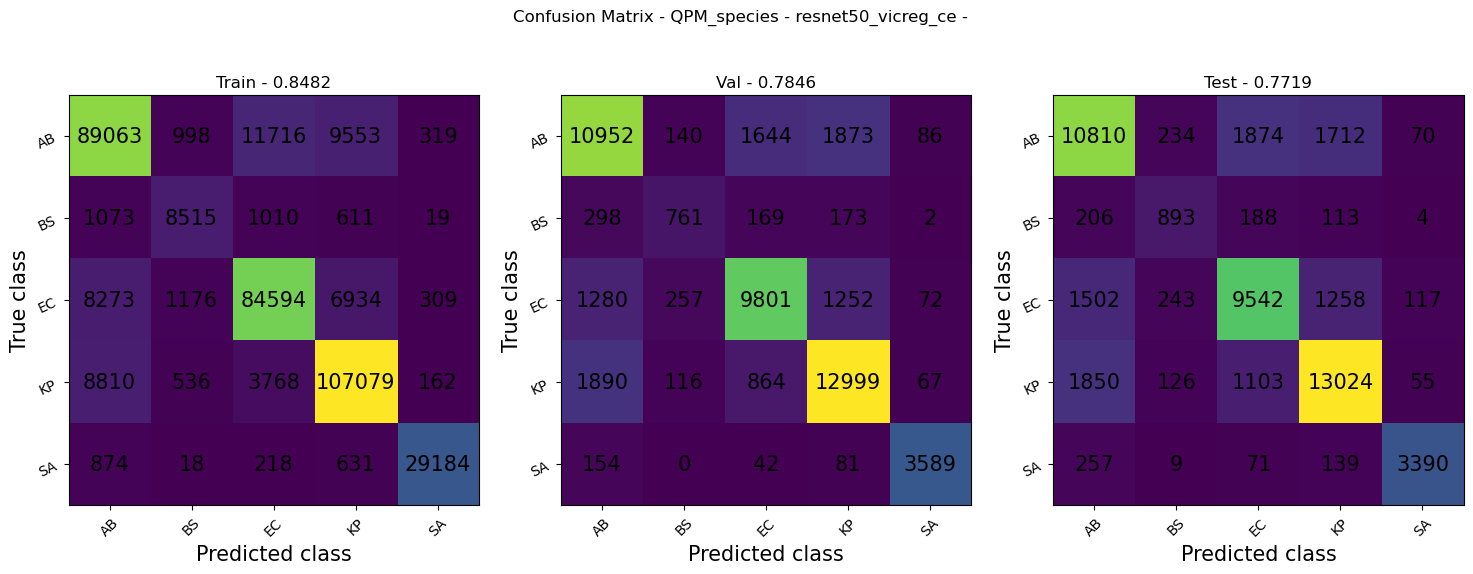

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


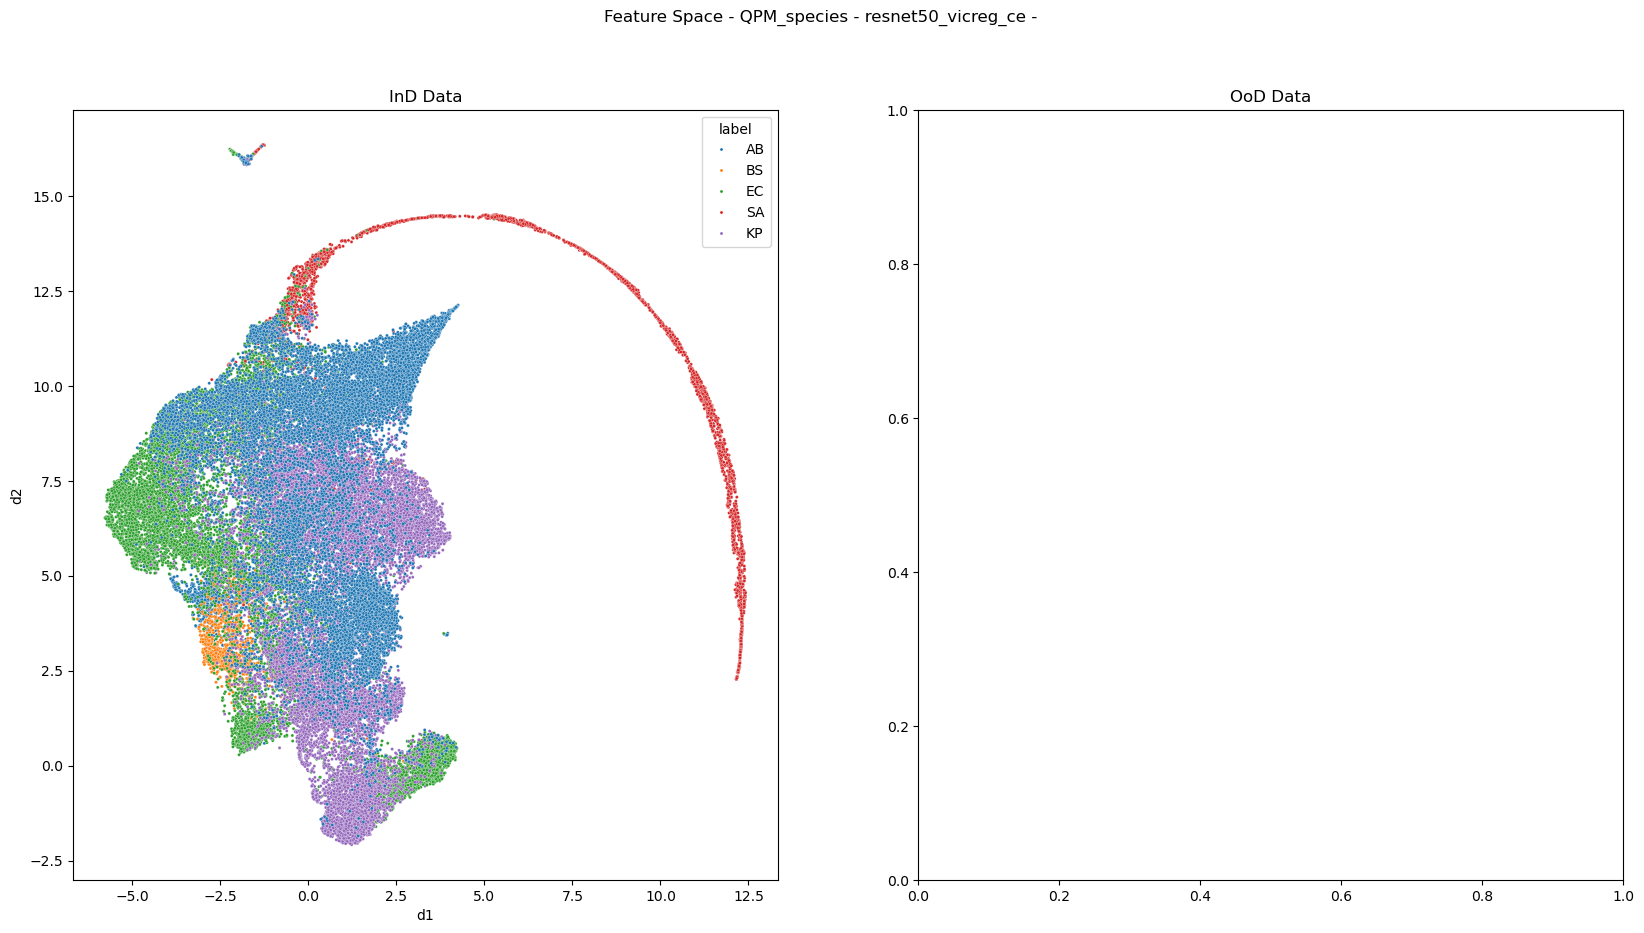

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

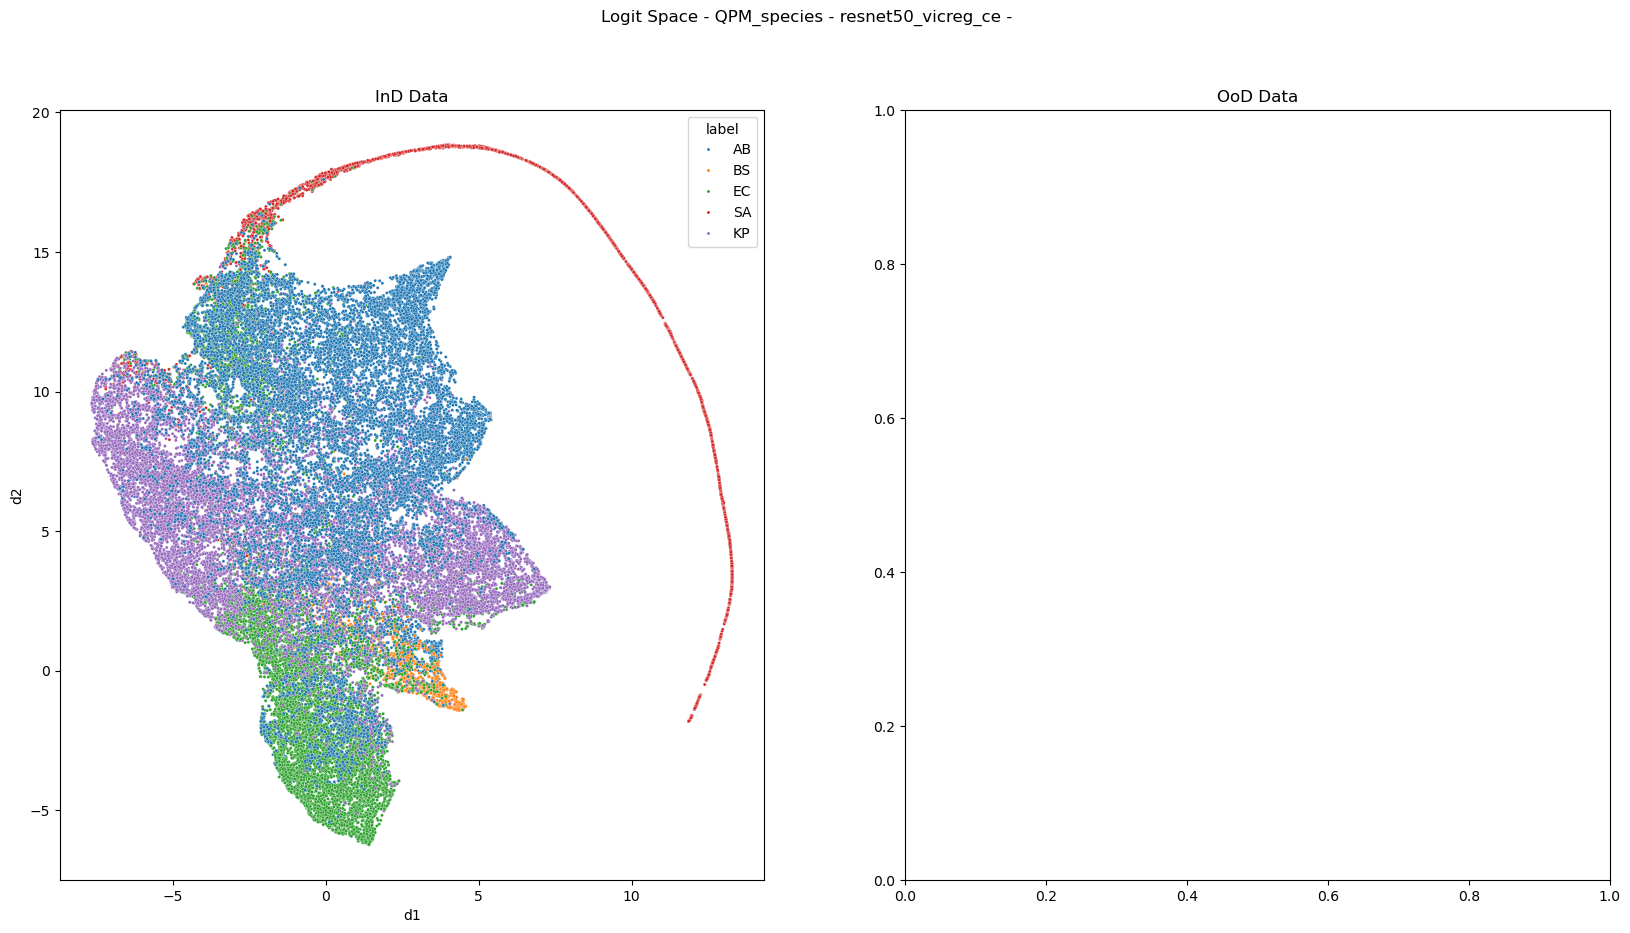

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

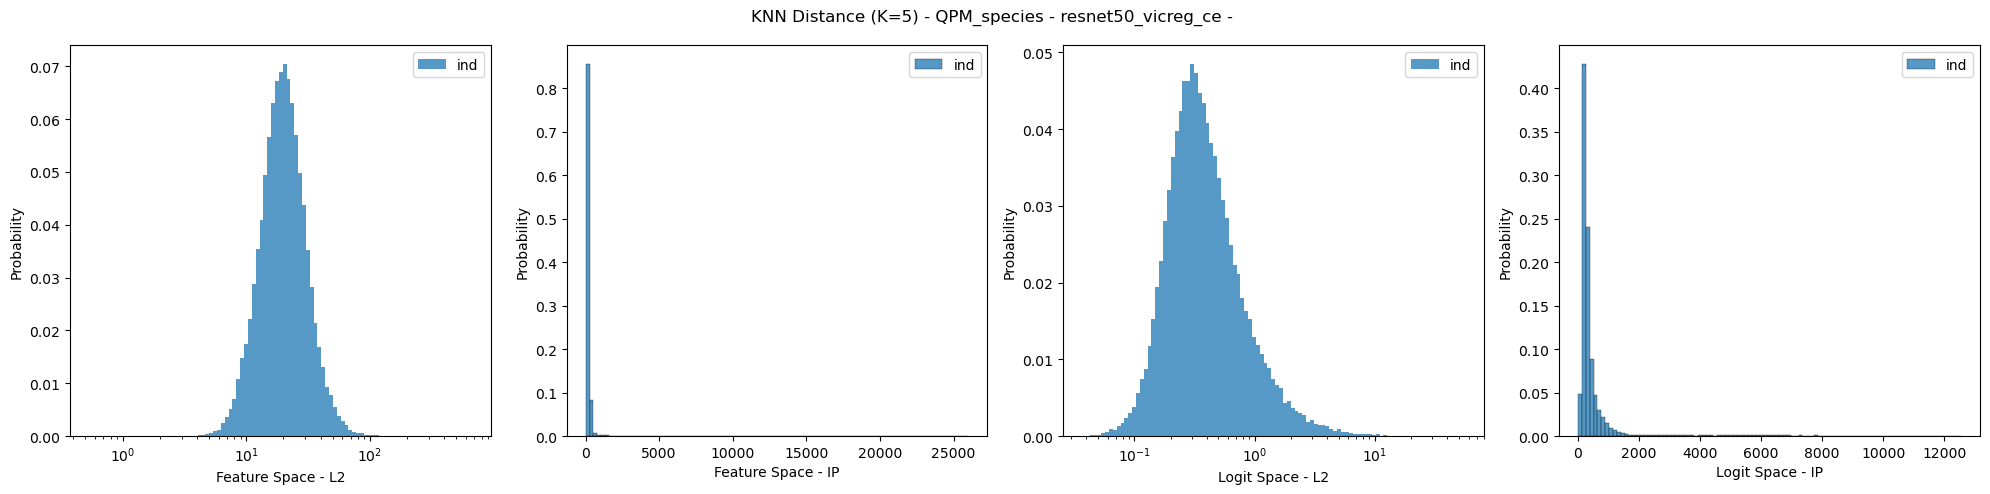

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

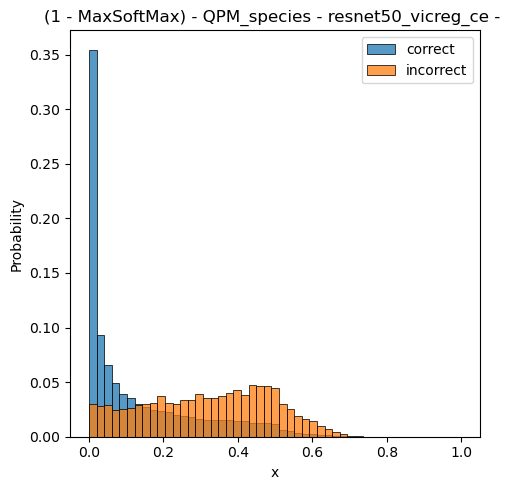

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()